# Hash-Based Dimensionality Reduction for Online Machine Learning

### Initialization

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import numpy as np
import mmh3
from sklearn.datasets import fetch_20newsgroups
from sklearn.utils import shuffle


In [69]:
np.random.seed(42)

K_VALS = [2**i for i in range(10, 12)]      # Number of destination dimensions
C_VALS = [2, 4]                             # Number of hash functions for MFH

In [70]:
X, y = fetch_20newsgroups(subset='all', return_X_y=True)

In [71]:
vec = TfidfVectorizer(stop_words='english')

X_bow = vec.fit_transform(X)
feature_names = vec.get_feature_names_out()
N, D = X_bow.shape
print(f'Number of samples: {N}, number of features: {D}, number of classes: {len(np.unique(y))}')
print(f'Average number of non-zero features per sample: {X_bow.nnz / N:.5f}')

Number of samples: 18846, number of features: 173451, number of classes: 20
Average number of non-zero features per sample: 113.66205


### Baseline Model Predictions

In [72]:
class OnlineGradientDescent:
    def __init__(self, lr=0.01, epochs=10, batch_size=256, l2=0.1):
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2 = l2
        self.W = None

    def softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def compute_grad_and_loss(self, X_batch, y_batch):
        logits = X_batch @ self.W
        probs = self.softmax(logits)
        grad = X_batch.T @ (probs - y_batch) / self.batch_size
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        return grad, loss

    def fit(self, X, y):
        N, D = X.shape
        n_classes = len(np.unique(y))
        self.W = np.random.randn(D, n_classes) * 0.001  # Initialize weights
        
        # One-hot encode labels
        y_one_hot = np.eye(n_classes)[y]

        for epoch in range(self.epochs):
            indices = np.arange(N)
            np.random.shuffle(indices)
            X, y_one_hot = X[indices], y_one_hot[indices]

            epoch_loss = 0
            for i in range(0, N, self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]

                grad, batch_loss = self.compute_grad_and_loss(X_batch, y_batch)
                
                # L2 regularization
                grad += 2 * self.l2 * self.W
                batch_loss += self.l2 * np.sum(self.W ** 2)
                
                self.W -= self.lr * grad
                epoch_loss += batch_loss

            print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

    def predict(self, X):
        logits = X @ self.W
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X_bow, y, test_size=0.2, random_state=42)

ogd = OnlineGradientDescent()
ogd.fit(X_train, y_train)

y_pred = ogd.predict(X_test)
baseline_score = accuracy_score(y_test, y_pred)
print(f"Baseline accuracy: {baseline_score:.4f}")

Epoch 1, Loss: 195.0086
Epoch 2, Loss: 191.1406
Epoch 3, Loss: 188.0863
Epoch 4, Loss: 185.6747
Epoch 5, Loss: 183.7705
Epoch 6, Loss: 182.2670
Epoch 7, Loss: 181.0798
Epoch 8, Loss: 180.1424
Epoch 9, Loss: 179.4022
Epoch 10, Loss: 178.8178
Baseline accuracy: 0.7645


In [74]:
def dense_X(bow, feature_names):
    """
    Prepare feature matrix for hashing
    :param bow: Bag of words matrix
    :return: List of feature names and values
    """
    X = []
    for i in range(bow.shape[0]):
        row_indices = bow[i].indices
        row_values = bow[i].data
        row_vals = [(feature_names[j], row_values[idx]) for idx, j in enumerate(row_indices)]
        X.append(row_vals)
    return X

X_dense_bow = dense_X(X_bow, feature_names)

### Feature Hashing

In [75]:
class FeatureHashingGD:
    def __init__(self, n_features, feature_names, lr=0.01, epochs=10, batch_size=256, l2=0.1):
        self.n_features = n_features
        self.feature_names = feature_names
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2 = l2
        self.hashes = self._hash_features(seed=0)
        self.signs = self._hash_signs()
        self.V = None   # Hashed weights (for classification)
    
    def _hash_signs(self):
        """Randomly assign signs to features for hashing."""
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash each feature name into a corresponding integer."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def transform(self, X):
        """Transform input features into a hashed feature space."""
        X_hashed = np.zeros((len(X), self.n_features))
        
        for i in range(len(X)):
            for feature, value in X[i]:
                if feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                h = self.hashes[idx] % self.n_features
                s = self.signs[idx]
                X_hashed[i, h] += s * value
                
        return X_hashed
    
    def softmax(self, logits):
        """Compute the softmax of logits."""
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    def compute_grad_and_loss(self, X_batch, y_batch):
        """Compute the gradient and loss for a batch."""
        logits = X_batch @ self.V
        probs = self.softmax(logits)
        
        grad = X_batch.T @ (probs - y_batch) / len(y_batch) 
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        
        return grad, loss
    
    def fit(self, X, y):
        """Train the model using hashed weights and gradient descent."""
        n_classes = len(np.unique(y))
        self.V = np.random.randn(self.n_features, n_classes) * 0.001
        y_one_hot = np.eye(n_classes)[y]
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X, y_one_hot = [X[i] for i in indices], y_one_hot[indices]
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]
                
                X_batch_hashed = self.transform(X_batch)
                
                grad, batch_loss = self.compute_grad_and_loss(X_batch_hashed, y_batch)
                
                # L2 regularization
                grad += 2 * self.l2 * self.V
                batch_loss += self.l2 * np.sum(self.V ** 2)
                
                self.V -= self.lr * grad
                epoch_loss += batch_loss
            
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.5f}")
    
    def predict(self, X):
        """Make predictions using the trained model."""
        X_hashed = self.transform(X)
        logits = X_hashed @ self.V
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)


In [76]:
X_train, X_test, y_train, y_test = train_test_split(X_dense_bow, y, test_size=0.2, random_state=42)

fh_scores = []
for n_features in K_VALS:
    print(f"Training with {n_features} features")
    fh = FeatureHashingGD(n_features, feature_names)
    fh.fit(X_train, y_train)
    y_pred = fh.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    fh_scores.append(score)
    print(f"Accuracy: {score:.4f}")

Training with 1024 features
Epoch 1/10 - Loss: 176.84136
Epoch 2/10 - Loss: 176.79584
Epoch 3/10 - Loss: 176.75990
Epoch 4/10 - Loss: 176.73153
Epoch 5/10 - Loss: 176.70914
Epoch 6/10 - Loss: 176.69147
Epoch 7/10 - Loss: 176.67750
Epoch 8/10 - Loss: 176.66646
Epoch 9/10 - Loss: 176.65776
Epoch 10/10 - Loss: 176.65090
Accuracy: 0.6122
Training with 2048 features
Epoch 1/10 - Loss: 176.95346
Epoch 2/10 - Loss: 176.88449
Epoch 3/10 - Loss: 176.83003
Epoch 4/10 - Loss: 176.78705
Epoch 5/10 - Loss: 176.75308
Epoch 6/10 - Loss: 176.72630
Epoch 7/10 - Loss: 176.70513
Epoch 8/10 - Loss: 176.68843
Epoch 9/10 - Loss: 176.67521
Epoch 10/10 - Loss: 176.66481
Accuracy: 0.6828


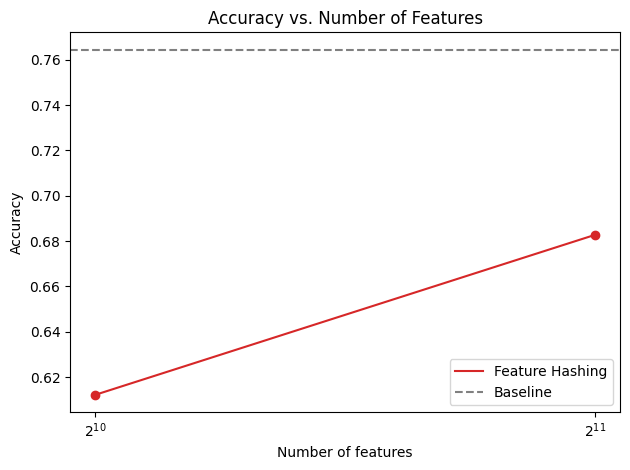

K         Accuracy  
1024      0.61220   
2048      0.68276   


In [77]:
fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color='tab:red', label='Feature Hashing')
ax1.scatter(K_VALS, fh_scores, color='tab:red')
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print(f"{'K':<10}{'Accuracy':<10}")
for i, k in enumerate(K_VALS):
    print(f"{k:<10}{fh_scores[i]:<10.5f}")

### Multi Feature Hashing

In [78]:
class MultiFeatureHashingGD():
    def __init__(self, n_features, feature_names, n_hashes=2, lr=0.01, epochs=10, batch_size=256, l2=0.1):
        self.n_features = n_features
        self.feature_names = list(feature_names)
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.n_hashes = n_hashes
        self.signs = self._hash_signs()
        self.hashes = [self._hash_features(seed=i) for i in range(n_hashes)]
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.l2 = l2
        self.V = None

    def _hash_signs(self):
        """Randomly assign signs to features for hashing."""
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash each feature name into a corresponding integer."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def transform(self, X):
        """Transform input features into a hashed feature space."""
        X_hashed = np.zeros((len(X), self.n_features))
        
        for i in range(len(X)):
            for feature, value in X[i]:
                if feature not in self.feature_to_idx:
                    continue
                idx = self.feature_to_idx[feature]
                hs = [h[idx] % self.n_features for h in self.hashes]
                s = self.signs[idx]
                for h in hs:
                    X_hashed[i, h] += s * value / self.n_hashes**0.5
        
        return X_hashed
    
    def softmax(self, logits):
        """Compute the softmax of logits."""
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    def compute_grad_and_loss(self, X_batch, y_batch):
        """Compute the gradient and loss for a batch."""
        logits = X_batch @ self.V
        probs = self.softmax(logits)
        
        grad = X_batch.T @ (probs - y_batch) / len(y_batch) 
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        
        return grad, loss
    
    def fit(self, X, y):
        """Train the model using hashed weights and gradient descent."""
        n_classes = len(np.unique(y))
        self.V = np.random.randn(self.n_features, n_classes) * 0.001
        y_one_hot = np.eye(n_classes)[y]
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X, y_one_hot = [X[i] for i in indices], y_one_hot[indices]
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]
                
                X_batch_hashed = self.transform(X_batch)
                
                grad, batch_loss = self.compute_grad_and_loss(X_batch_hashed, y_batch)
                
                # L2 regularization
                grad += 2 * self.l2 * self.V
                batch_loss += self.l2 * np.sum(self.V ** 2)
                
                self.V -= self.lr * grad
                epoch_loss += batch_loss
            
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.5f}")
            
    def predict(self, X):
        """Make predictions using the trained model."""
        X_hashed = self.transform(X)
        logits = X_hashed @ self.V
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)

In [79]:
mfh_scores = []

for n_hashes in C_VALS:
    print(f'Hashing with {n_hashes} hashes')
    scores = []
    for n_features in K_VALS:
        print(f"Training with {n_features} features")
        mfh = MultiFeatureHashingGD(n_features, feature_names, n_hashes)
        mfh.fit(X_train, y_train)
        y_pred = mfh.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)
        print(f"Accuracy: {score:.4f}")
    mfh_scores.append(scores)

Hashing with 2 hashes
Training with 1024 features
Epoch 1/10 - Loss: 176.84216
Epoch 2/10 - Loss: 176.79614
Epoch 3/10 - Loss: 176.75982
Epoch 4/10 - Loss: 176.73113
Epoch 5/10 - Loss: 176.70852
Epoch 6/10 - Loss: 176.69062
Epoch 7/10 - Loss: 176.67651
Epoch 8/10 - Loss: 176.66536
Epoch 9/10 - Loss: 176.65656
Epoch 10/10 - Loss: 176.64962
Accuracy: 0.6066
Training with 2048 features
Epoch 1/10 - Loss: 176.95450
Epoch 2/10 - Loss: 176.88518
Epoch 3/10 - Loss: 176.83044
Epoch 4/10 - Loss: 176.78723
Epoch 5/10 - Loss: 176.75310
Epoch 6/10 - Loss: 176.72616
Epoch 7/10 - Loss: 176.70490
Epoch 8/10 - Loss: 176.68809
Epoch 9/10 - Loss: 176.67484
Epoch 10/10 - Loss: 176.66436
Accuracy: 0.6745
Hashing with 4 hashes
Training with 1024 features
Epoch 1/10 - Loss: 176.84329
Epoch 2/10 - Loss: 176.79723
Epoch 3/10 - Loss: 176.76089
Epoch 4/10 - Loss: 176.73221
Epoch 5/10 - Loss: 176.70952
Epoch 6/10 - Loss: 176.69164
Epoch 7/10 - Loss: 176.67751
Epoch 8/10 - Loss: 176.66638
Epoch 9/10 - Loss: 176.6

KeyboardInterrupt: 

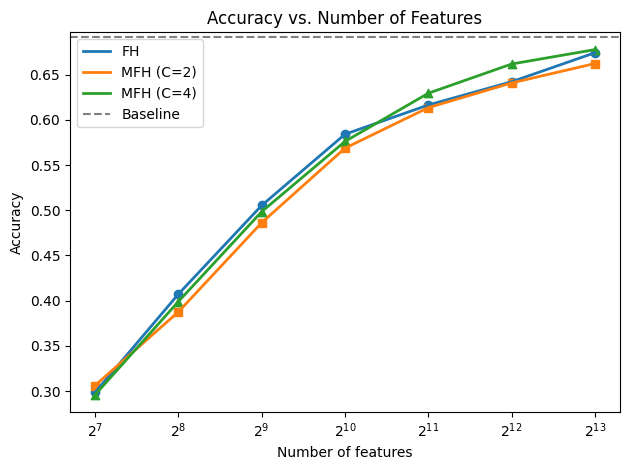

Accuracies:
K\C	FH	MFH2	MFH4
128	0.29841	0.30610	0.29576
256	0.40716	0.38753	0.39894
512	0.50531	0.48621	0.49841
1024	0.58408	0.56870	0.57613
2048	0.61645	0.61353	0.62944
4096	0.64218	0.64085	0.66180
8192	0.67427	0.66233	0.67772

In [49]:
import matplotlib.pyplot as plt

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
markers = ['o', 's', '^', 'D', 'x', '*']

fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color=colors[0], label='FH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, scores in enumerate(mfh_scores):
    ax1.plot(K_VALS, scores, color=colors[(i+1) % len(colors)], label=f'MFH (C={C_VALS[i]})', linestyle='-', linewidth=2)
    ax1.scatter(K_VALS, scores, color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print('Accuracies:')
print('K\\C\tFH', end='')
for C in C_VALS:
    print(f'\tMFH{C}', end='')
    
for i, K in enumerate(K_VALS):
    print(f'\n{K}', end='')
    print(f'\t{fh_scores[i]:.5f}', end='')
    for j, C in enumerate(C_VALS):
        print(f'\t{mfh_scores[j][i]:.5f}', end='')

### Cuckoo Hashing

In [ ]:
import numpy as np
import mmh3

class CuckooFeatureHashingGD():
    def __init__(self, n_features, feature_names, q_ratio=0.2, lr=0.01, epochs=10, batch_size=256):
        self.n_features = n_features
        self.feature_names = list(feature_names)
        self.feature_to_idx = {f: i for i, f in enumerate(feature_names)}
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        
        self.hashes_1 = self._hash_features(seed=0)
        self.hashes_2 = self._hash_features(seed=1)
        self.hashes_H = self._hash_features(seed=2)
        self.signs = self._hash_signs()
        
        self.q_ratio = q_ratio
        self.dim_q = max(1, int(self.q_ratio * self.n_features))
        self.q = np.zeros(self.dim_q)
        
        self.V = None  # Weight matrix, will be learned

    def _hash_signs(self):
        """Randomly assign signs to features for hashing."""
        return np.array(np.random.choice([-1, 1], size=len(self.feature_names)), dtype=np.int64)
    
    def _hash_features(self, seed):
        """Hash each feature name into a corresponding integer."""
        return np.array([mmh3.hash(f.encode('utf-8'), seed, signed=False) for f in self.feature_names], dtype=np.int64)
    
    def _get_bucket_indices(self, feature_idx):
        """Get the bucket indices for a feature index."""
        h1 = self.hashes_1[feature_idx] % self.n_features
        h2 = self.hashes_2[feature_idx] % self.n_features
        H_idx = self.hashes_H[feature_idx] % self.dim_q
        s = self.signs[feature_idx]
        return h1, h2, H_idx, s
    
    def transform(self, X):
        """Transform input features into a hashed feature space."""
        X_hashed = np.zeros((len(X), self.n_features))
        
        for i in range(len(X)):
            for feature, value in X[i]:
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                X_hashed[i, h1] += value * self.q[H_idx] * s
                X_hashed[i, h2] += value * (1 - self.q[H_idx]) * s
                
        return X_hashed
    
    def softmax(self, logits):
        """Compute the softmax of logits."""
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
    
    def compute_grad_and_loss(self, X_batch, y_batch):
        X_batch_hashed = self.transform(X_batch)
        logits = X_batch_hashed @ self.V
        probs = self.softmax(logits)
        loss = -np.mean(np.sum(y_batch * np.log(probs + 1e-8), axis=1))
        
        error = probs - y_batch
        
        # Gradient of loss w.r.t V
        grad_V = X_batch_hashed.T @ error / len(y_batch)
        
        # Gradient of loss w.r.t q
        grad_q = np.zeros_like(self.q)
        for i in range(len(X_batch)):
            for feature, value in X_batch[i]:
                idx = self.feature_to_idx[feature]
                h1, h2, H_idx, s = self._get_bucket_indices(idx)
                grad_q[H_idx] += s * value * (self.V[h1] - self.V[h2]) @ error[i]
        grad_q /= len(y_batch)
        
        return grad_V, grad_q, loss
        
    def fit(self, X, y):
        """Train the model using gradient descent with hashed weights."""
        n_classes = len(np.unique(y))
        self.V = np.random.randn(self.n_features, n_classes) * 0.001
        y_one_hot = np.eye(n_classes)[y]
        
        for epoch in range(self.epochs):
            epoch_loss = 0
            indices = np.arange(len(X))
            np.random.shuffle(indices)
            X, y_one_hot = [X[i] for i in indices], y_one_hot[indices]
            
            for i in range(0, len(X), self.batch_size):
                X_batch = X[i:i+self.batch_size]
                y_batch = y_one_hot[i:i+self.batch_size]
                                                
                grad_V, grad_q, batch_loss = self.compute_grad_and_loss(X_batch, y_batch)
                
                self.V -= self.lr * grad_V 
                self.q -= self.lr * 0.1 * grad_q 
                self.q = np.clip(self.q, 0, 1)
                
                epoch_loss += batch_loss
            
            print(f"Epoch {epoch+1}/{self.epochs} - Loss: {epoch_loss:.5f}")
            
    def predict(self, X):
        """Make predictions using the trained model."""
        X_hashed = self.transform(X)
        logits = X_hashed @ self.V
        probs = self.softmax(logits)
        return np.argmax(probs, axis=1)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_dense_bow, y, test_size=0.2, random_state=42)

cfh_scores = []
for n_features in K_VALS:
    print(f"Training with {n_features} features")
    cfh = CuckooFeatureHashingGD(n_features, feature_names)
    cfh.fit(X_train, y_train)
    y_pred = cfh.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    cfh_scores.append(score)
    print(f"Accuracy: {score:.4f}")

Training with 128 features
Epoch 1/10 - Loss: 176.73504
Epoch 2/10 - Loss: 176.70709
Epoch 3/10 - Loss: 176.67915
Epoch 4/10 - Loss: 176.65125
Epoch 5/10 - Loss: 176.62331
Epoch 6/10 - Loss: 176.59542
Epoch 7/10 - Loss: 176.56758
Epoch 8/10 - Loss: 176.53968
Epoch 9/10 - Loss: 176.51180
Epoch 10/10 - Loss: 176.48398
Accuracy: 0.3034
Training with 256 features
Epoch 1/10 - Loss: 176.73489
Epoch 2/10 - Loss: 176.70501
Epoch 3/10 - Loss: 176.67512
Epoch 4/10 - Loss: 176.64524
Epoch 5/10 - Loss: 176.61539
Epoch 6/10 - Loss: 176.58552
Epoch 7/10 - Loss: 176.55565
Epoch 8/10 - Loss: 176.52587
Epoch 9/10 - Loss: 176.49604
Epoch 10/10 - Loss: 176.46619
Accuracy: 0.3905
Training with 512 features
Epoch 1/10 - Loss: 176.73680
Epoch 2/10 - Loss: 176.70791
Epoch 3/10 - Loss: 176.67904
Epoch 4/10 - Loss: 176.65016
Epoch 5/10 - Loss: 176.62131
Epoch 6/10 - Loss: 176.59242
Epoch 7/10 - Loss: 176.56356
Epoch 8/10 - Loss: 176.53471
Epoch 9/10 - Loss: 176.50593
Epoch 10/10 - Loss: 176.47709
Accuracy: 0.

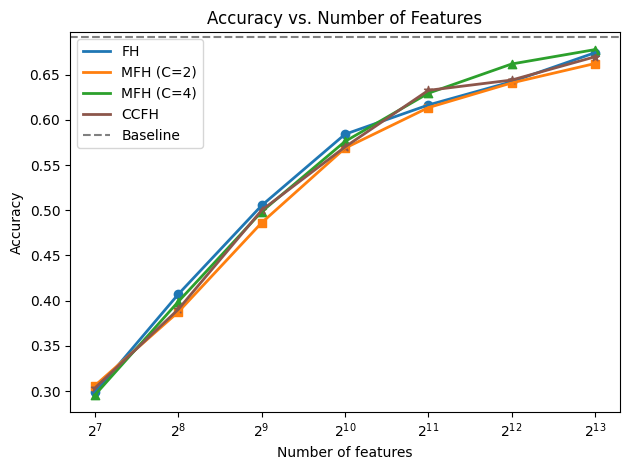

Accuracies:
K\C	FH	MFH2	MFH4	CCFH
128	0.29841	0.30610	0.29576	0.30345
256	0.40716	0.38753	0.39894	0.39045
512	0.50531	0.48621	0.49841	0.50000
1024	0.58408	0.56870	0.57613	0.57003
2048	0.61645	0.61353	0.62944	0.63263
4096	0.64218	0.64085	0.66180	0.64403
8192	0.67427	0.66233	0.67772	0.66976


In [52]:
fig, ax1 = plt.subplots()

ax1.set_title('Accuracy vs. Number of Features')
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Accuracy')
ax1.plot(K_VALS, fh_scores, color=colors[0], label='FH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, fh_scores, color=colors[0], marker=markers[0])
for i, scores in enumerate(mfh_scores):
    ax1.plot(K_VALS, scores, color=colors[(i+1) % len(colors)], label=f'MFH (C={C_VALS[i]})', linestyle='-', linewidth=2)
    ax1.scatter(K_VALS, scores, color=colors[(i+1) % len(colors)], marker=markers[(i+1) % len(markers)])
ax1.plot(K_VALS, cfh_scores, color=colors[-1], label='CCFH', linestyle='-', linewidth=2)
ax1.scatter(K_VALS, cfh_scores, color=colors[-1], marker=markers[-1])
ax1.axhline(y=baseline_score, color='gray', linestyle='--', label='Baseline')
ax1.set_xscale('log', base=2)
ax1.legend()

plt.tight_layout()
plt.show()

print('Accuracies:')
print('K\\C\tFH', end='')
for C in C_VALS:
    print(f'\tMFH{C}', end='')
print('\tCCFH')
for i, K in enumerate(K_VALS):
    print(f'{K}', end='')
    print(f'\t{fh_scores[i]:.5f}', end='')
    for j, C in enumerate(C_VALS):
        print(f'\t{mfh_scores[j][i]:.5f}', end='')
    print(f'\t{cfh_scores[i]:.5f}', end='')
    print()